# Identification of digits from sign language images 

In [18]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Import relevant libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
# Image Settings
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2

In [21]:
# Define get images function
def get_img(data_path):
    # Getting image array from path:
    img = cv2.imread(data_path)
    img = cv2.resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img

## Analyze dataset

Number of samples for digit 0: 205
Number of samples for digit 1: 206
Number of samples for digit 2: 206
Number of samples for digit 3: 206
Number of samples for digit 4: 207
Number of samples for digit 5: 207
Number of samples for digit 6: 207
Number of samples for digit 7: 206
Number of samples for digit 8: 208
Number of samples for digit 9: 204


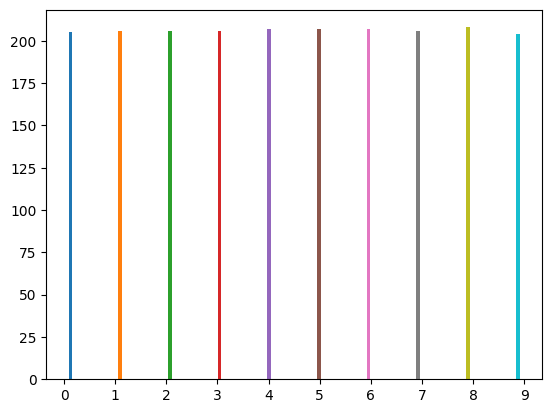

In [22]:
# Plot the number of samples for each sign languagem digit
dataset_path = "dataset/raw/"
data_distribution = {}

labels = os.listdir(dataset_path)  # Getting labels
labels.sort()  # Sorting labels
for i, label in enumerate(labels):
    data_path = dataset_path + label
    for img in os.listdir(data_path):
        img_path = data_path + "/" + img
        img_read = cv2.imread(img_path)

        if label in data_distribution:
            data_distribution[label].append(img_read)
        else:
            data_distribution[label] = [img_read]
    

for label in data_distribution:
    print("Number of samples for digit " + label + ": " + str(len(data_distribution[label])))

#TODO: Plot a better histogram (label each bar with the total number of samples)
counts, edges, bars = plt.hist([[key]*len(data_distribution[key]) for key in data_distribution.keys()], bins=10)
plt.show()
        

- We have a pretty balanced dataset

## Data Preprocessing 

For the preprocessing we will be resizing and converting each image to grayscale. We will also be flatening them

In [23]:
# Resize function
def resize(img):
    width = 50
    height = 50
    dim = (width, height)

    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

# Convert image to grayscale
def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

# Flatten image
def flatten(img):
    data = np.array(img)

    flattened = data.flatten()
    return flattened

In [24]:
# Define Save and Load Model functions

import pickle
def save_model(filename, model):
    pickle.dump(model, open("models/"+filename, 'wb'))

def load_model(filename):
    return pickle.load(open("models/"+filename, 'rb'))


In [25]:
# Deal with the dataset images

images = []
labels = []

for label in data_distribution:
    for img in data_distribution[label]:
        img_resized = resize(img)
        img_grayscale = grayscale(img_resized)
        img_flattened = flatten(img_grayscale)

        images.append(img_flattened)
        labels.append(label)
images = np.asarray(images)
labels = np.asarray(labels)

In [26]:
# Split data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=58)   

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1649, 2500) (1649,)
(413, 2500) (413,)


In [27]:
# Define train and analyse model functions
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, cross_validate


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def train_and_analyze(model, X_train, y_train, X_test, y_test):
    trained_model = model.fit(X_train, y_train)
    
    print(f"> Model: {model.__class__}\n")
    
    X_test_prediction = model.predict(X_test)
    test_data_accuracy = accuracy_score(X_test_prediction, y_test)
    f1 = f1_score(y_test, X_test_prediction, average='weighted')

    print()
    print("---- Model Analysis ----")
    print('Accuracy: ', test_data_accuracy)
    print('F1 Score: ', f1)
    
    print()
    
    print("Confusion Matrix: ")
    cm = confusion_matrix(y_test, model.predict(X_test))
    plot_confusion_matrix(cm, target_names=[str(i) for i in range(10)], normalize=False)
    plt.show()
    
    print()
    print("---- Classification Report ----")
    print(classification_report(y_test, model.predict(X_test)))

    return trained_model

def hyperparameters(model, params, X, y):
    """
    Find hyperparameters for a model
    """
    print("> Hyper Parameter Tuning")
    print("Finding Best Params for Model ", model.__class__)
    model = GridSearchCV(model, params, scoring="accuracy")
    model.fit(X, y)
    print(" Best Params: ")
    print(model.best_params_)
    
    return model.best_params_


def kfold(model, k, X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=k, shuffle=True)
    scores = cross_validate(model, X_train, y_train, scoring="accuracy", cv=k, return_estimator=True)
    return scores["estimator"][np.argmax(scores["test_score"])]

# Basic Models without Parameter Tuning

## Logistic Regression

> Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


---- Model Analysis ----
Accuracy:  0.7699757869249395
F1 Score:  0.7718090845039223

Confusion Matrix: 


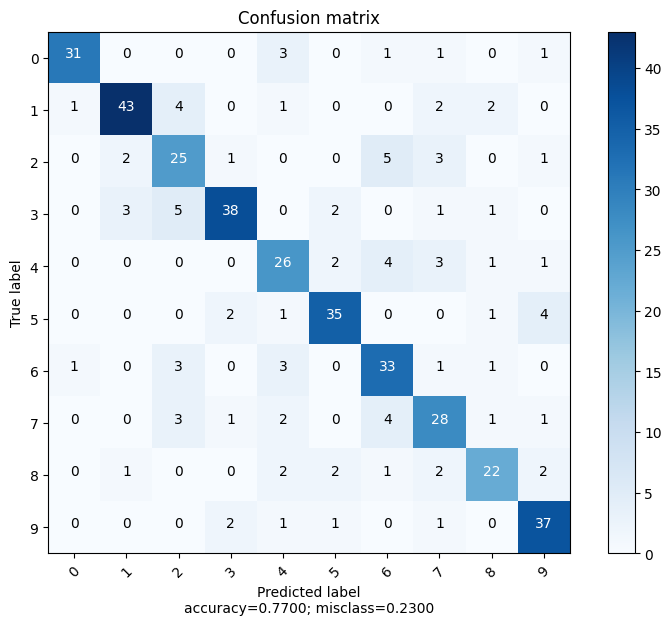


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        37
           1       0.88      0.81      0.84        53
           2       0.62      0.68      0.65        37
           3       0.86      0.76      0.81        50
           4       0.67      0.70      0.68        37
           5       0.83      0.81      0.82        43
           6       0.69      0.79      0.73        42
           7       0.67      0.70      0.68        40
           8       0.76      0.69      0.72        32
           9       0.79      0.88      0.83        42

    accuracy                           0.77       413
   macro avg       0.77      0.77      0.77       413
weighted avg       0.78      0.77      0.77       413



In [28]:
from sklearn.linear_model import LogisticRegression
logisticRegr = train_and_analyze(LogisticRegression(), x_train, y_train, x_test, y_test)

save_model("logistic_regression.sav", logisticRegr)

## Decision Tree Model

> Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>


---- Model Analysis ----
Accuracy:  0.5811138014527845
F1 Score:  0.581983895628251

Confusion Matrix: 


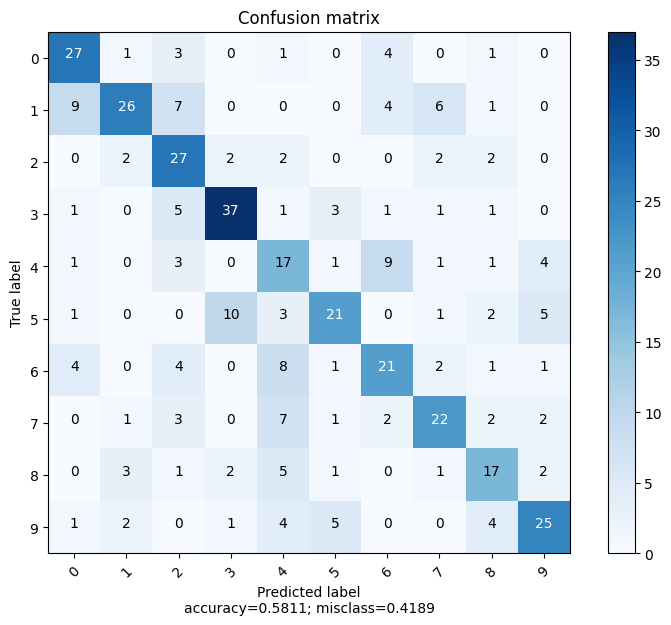


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.61      0.73      0.67        37
           1       0.74      0.49      0.59        53
           2       0.51      0.73      0.60        37
           3       0.71      0.74      0.73        50
           4       0.35      0.46      0.40        37
           5       0.64      0.49      0.55        43
           6       0.51      0.50      0.51        42
           7       0.61      0.55      0.58        40
           8       0.53      0.53      0.53        32
           9       0.64      0.60      0.62        42

    accuracy                           0.58       413
   macro avg       0.59      0.58      0.58       413
weighted avg       0.60      0.58      0.58       413



In [29]:
from sklearn import tree
clf = train_and_analyze(tree.DecisionTreeClassifier(), x_train, y_train, x_test, y_test)

save_model("decision_tree.sav", clf)


## Random Forest Classifier

> Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


---- Model Analysis ----
Accuracy:  0.7869249394673123
F1 Score:  0.7889429265261935

Confusion Matrix: 


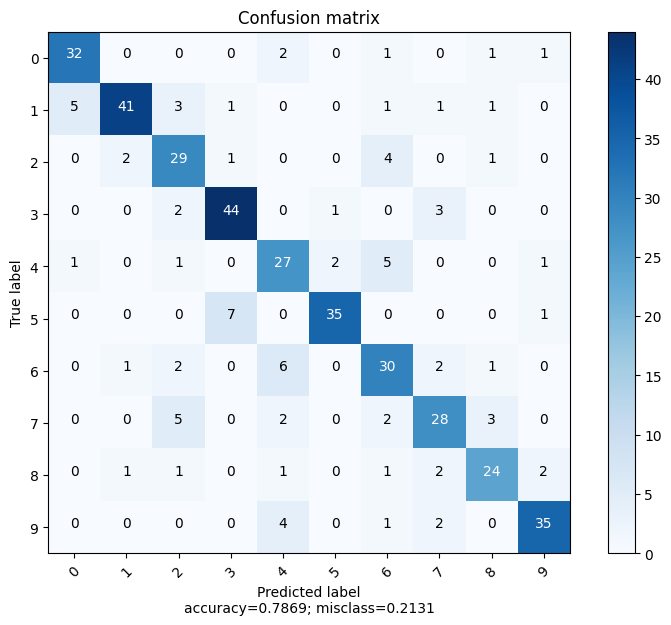


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        37
           1       0.91      0.77      0.84        53
           2       0.67      0.78      0.72        37
           3       0.83      0.88      0.85        50
           4       0.64      0.73      0.68        37
           5       0.92      0.81      0.86        43
           6       0.67      0.71      0.69        42
           7       0.74      0.70      0.72        40
           8       0.77      0.75      0.76        32
           9       0.88      0.83      0.85        42

    accuracy                           0.79       413
   macro avg       0.79      0.78      0.78       413
weighted avg       0.79      0.79      0.79       413



In [30]:
from sklearn.ensemble import RandomForestClassifier
clf_rft = train_and_analyze(RandomForestClassifier(), x_train, y_train, x_test, y_test)

save_model("random_forest.sav", clf_rft)


## Naive Bayes

> Model: <class 'sklearn.naive_bayes.GaussianNB'>


---- Model Analysis ----
Accuracy:  0.6222760290556901
F1 Score:  0.6245230763867611

Confusion Matrix: 


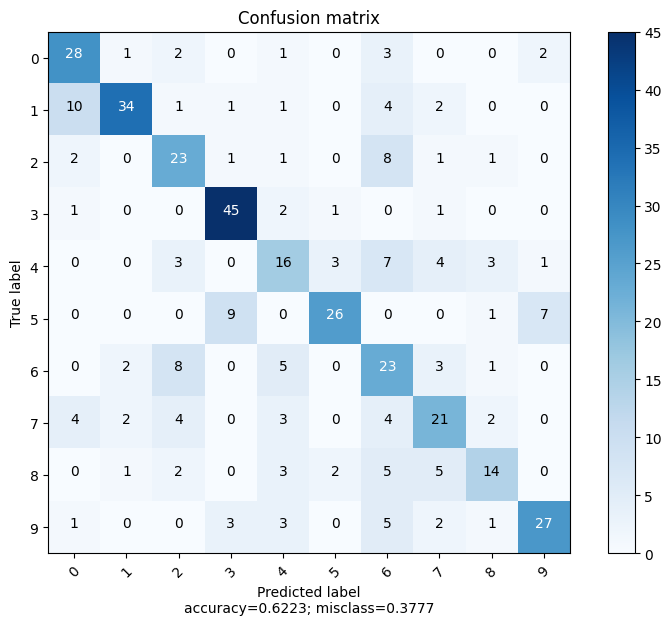


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.61      0.76      0.67        37
           1       0.85      0.64      0.73        53
           2       0.53      0.62      0.57        37
           3       0.76      0.90      0.83        50
           4       0.46      0.43      0.44        37
           5       0.81      0.60      0.69        43
           6       0.39      0.55      0.46        42
           7       0.54      0.53      0.53        40
           8       0.61      0.44      0.51        32
           9       0.73      0.64      0.68        42

    accuracy                           0.62       413
   macro avg       0.63      0.61      0.61       413
weighted avg       0.64      0.62      0.62       413



In [31]:
from sklearn.naive_bayes import GaussianNB 
gnb = train_and_analyze(GaussianNB(), x_train, y_train, x_test, y_test)

save_model("naive_bayes.sav", gnb)

## Models with Hypertuned Parameters

> Hyper Parameter Tuning
Finding Best Params for Model  <class 'sklearn.linear_model._logistic.LogisticRegression'>
 Best Params: 
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
> Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


---- Model Analysis ----
Accuracy:  0.7070217917675545
F1 Score:  0.712444559098485

Confusion Matrix: 


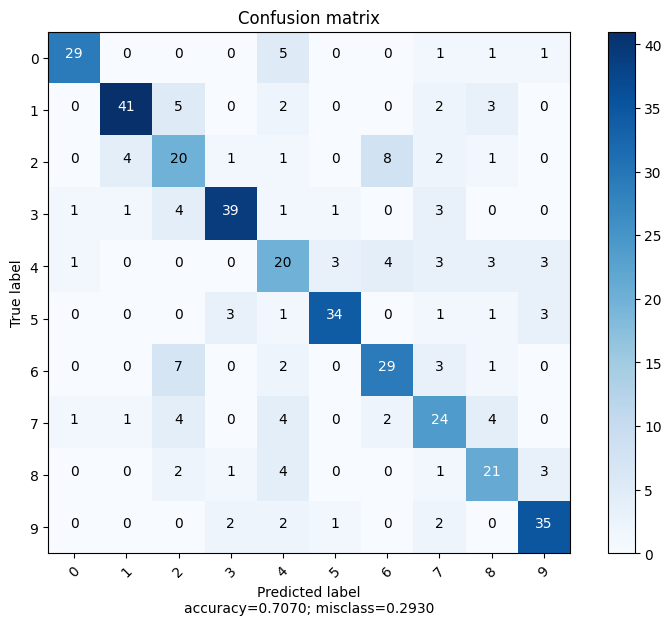


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        37
           1       0.87      0.77      0.82        53
           2       0.48      0.54      0.51        37
           3       0.85      0.78      0.81        50
           4       0.48      0.54      0.51        37
           5       0.87      0.79      0.83        43
           6       0.67      0.69      0.68        42
           7       0.57      0.60      0.59        40
           8       0.60      0.66      0.63        32
           9       0.78      0.83      0.80        42

    accuracy                           0.71       413
   macro avg       0.71      0.70      0.70       413
weighted avg       0.72      0.71      0.71       413



LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear')

In [32]:
hypertuned_model = LogisticRegression()

logreg_params = [{'solver': ['liblinear'], 'max_iter': [100, 400, 800],
                         'C': [0.1, 1, 10, 100, 1000], 'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2']}]
best_logreg_params = hyperparameters(LogisticRegression(), logreg_params , x_train, y_train)

hypertuned_model.set_params(**best_logreg_params)
train_and_analyze(hypertuned_model, x_train, y_train, x_test, y_test)